In [1]:
import numpy as np
from matplotlib import pyplot as plt

import csv
import os
import re
import numpy as np
from skimage.morphology import disk, dilation, erosion, closing, opening, remove_small_objects
from tqdm import tqdm
import pandas as pd
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, PairwiseKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.interpolate import griddata

from BO_utility import standardize, unstandardize, surrogate, acquisition, opt_acquisition




In [3]:
# Define Dataframe
csv_file_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'datasets',
    'quality_scores.csv'
))

df = pd.read_csv(csv_file_path, dtype={'Experiment': str})
df['Experiment'] = df['Experiment'].apply(lambda x: 'c'+x if len(x)==1 else x)

exps = {
    'control': ('c1','c4'),
    '0': ('001','052'),
    '1': ('056','067'),
    '2': ('068','078'),
    '3': ('079','088'),
    '4': ('089', '097'),
    '5': ('098', '122'),
    'control2': ('123','123')
}
dfc = pd.concat([df[(exps['control'][0] <= df['Experiment']) & (df['Experiment'] <= exps['control'][1])]])
df0 = pd.concat([df[(exps['0'][0] <= df['Experiment']) & (df['Experiment'] <= exps['0'][1])]])
df1 = pd.concat([df[(exps['1'][0] <= df['Experiment']) & (df['Experiment'] <= exps['1'][1])]])
df2 = pd.concat([df[(exps['2'][0] <= df['Experiment']) & (df['Experiment'] <= exps['2'][1])]])
df3 = pd.concat([df[(exps['3'][0] <= df['Experiment']) & (df['Experiment'] <= exps['3'][1])]])
df4 = pd.concat([df[(exps['4'][0] <= df['Experiment']) & (df['Experiment'] <= exps['4'][1])]])
df5 = pd.concat([df[(exps['5'][0] <= df['Experiment']) & (df['Experiment'] <= exps['5'][1])]])


training_data = pd.concat([df0,dfc])
sampled_data = pd.concat([df1,df2,df3,df4,df5])
all_df = pd.concat([training_data, sampled_data])
#current_df = pd.concat([df0, dfc])
current_df = training_data #all_df.copy()
#current_df = current_df[current_df['Area sum'] < 4500]
#current_df = current_df.sample(900, random_state=42)

In [4]:
# With the new dataset, fit some GP-like model, as suggest a new set of parameters
dims = 4

# Parameter Space
param_bounds = [
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=10, stop=100, num=46),
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=50, stop=300, num=101)
]

param_space = np.array( np.meshgrid(param_bounds[0],
                                    param_bounds[1],
                                    param_bounds[2],
                                    param_bounds[3])).T.reshape(-1,dims)
param_space[:,3] = np.floor(param_space[:,3])




# Initialize model
print('Initialize model...')

# RationalQuadratic, ExpSineSquared, DotProduct, PairwiseKernel

#kernel = ConstantKernel(0.00316**2, constant_value_bounds='fixed') + RBF(1.96,length_scale_bounds='fixed') + WhiteKernel(0.193, noise_level_bounds='fixed') 
kernel = ConstantKernel() + RBF() + WhiteKernel() 
model = GaussianProcessRegressor(kernel=kernel, 
                                 n_restarts_optimizer=10,
                                 random_state=42)

# Define init data
x_init = np.array(current_df[["Param1", "Param2", "Param3", "Param4"]].iloc[:,:])
x_init[:,3] = np.floor(x_init[:,3])
y_init = np.array(-current_df["Area sum"].iloc[:])

# Fit model on init data
print('Fit model...')
model.fit(standardize(x_init, x_init), standardize(y_init, y_init))
print(int(model.log_marginal_likelihood()))

Initialize model...
Fit model...
-386


In [5]:
mu, std = surrogate(model, standardize(x_init, param_space))
# mu, std = surrogate(model, standardize(x_init, x_init))

: 

: 

In [6]:
all = np.c_[(param_space, mu.reshape(-1,1), std.reshape(-1,1))]
concat_df = pd.DataFrame(all, columns=["Param1", "Param2", "Param3", "Param4", "mu", "std"])

p1 = -unstandardize(y_init,np.array(concat_df.groupby(['Param1'])['mu'].mean()))
p1s = np.array(concat_df.groupby(['Param1'])['std'].mean())* (y_init.std()+1e-9)
p2 = -unstandardize(y_init,np.array(concat_df.groupby(['Param2'])['mu'].mean()))
p2s = np.array(concat_df.groupby(['Param2'])['std'].mean())* (y_init.std()+1e-9)
p3 = -unstandardize(y_init,np.array(concat_df.groupby(['Param3'])['mu'].mean()))
p3s = np.array(concat_df.groupby(['Param3'])['std'].mean())* (y_init.std()+1e-9)
p4 = -unstandardize(y_init,np.array(concat_df.groupby(['Param4'])['mu'].mean()))
p4s = np.array(concat_df.groupby(['Param4'])['std'].mean())* (y_init.std()+1e-9)

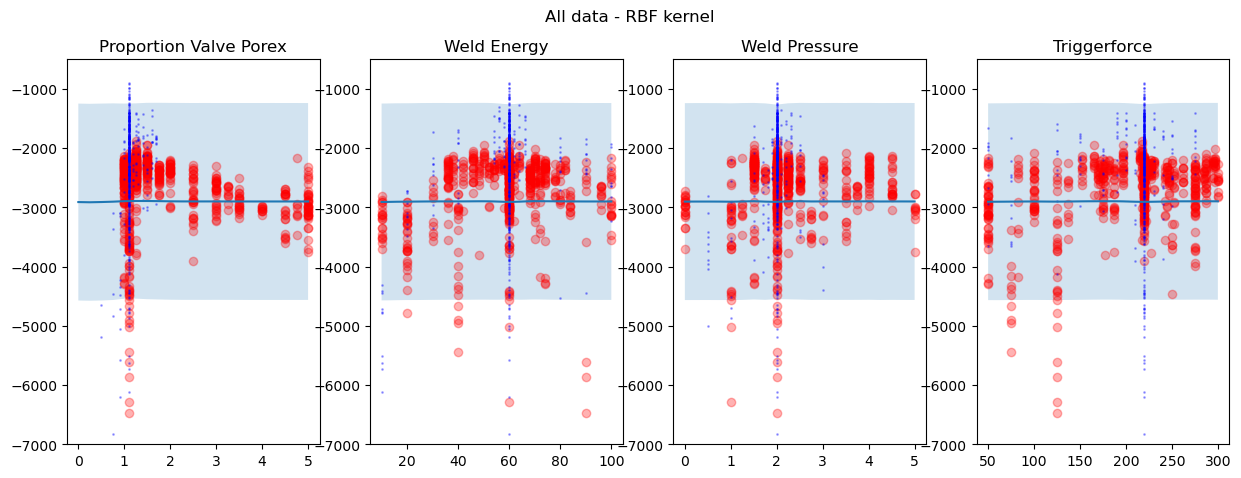

In [7]:
# plot 4 graphs
current_df = sampled_data.copy()
fig, axs = plt.subplots(1,4, figsize=(15,5))
axs[0].plot(np.linspace(0,5,21),-p1)
axs[0].fill_between(np.linspace(0,5,21), -p1-p1s, -p1+p1s, alpha=0.2)
axs[0].set_title("Proportion Valve Porex")
axs[0].scatter(current_df['Param1'], -current_df['Area sum'], color='red', alpha=0.3)

axs[1].plot(np.linspace(10,100,46),-p2)
axs[1].fill_between(np.linspace(10,100,46), -p2-p2s, -p2+p2s, alpha=0.2)
axs[1].set_title("Weld Energy")
axs[1].scatter(current_df['Param2'], -current_df['Area sum'], color='red', alpha=0.3)

axs[2].plot(np.linspace(0,5,21),-p3)
axs[2].fill_between(np.linspace(0,5,21), -p3-p3s, -p3+p3s, alpha=0.2)
axs[2].set_title("Weld Pressure")
axs[2].scatter(current_df['Param3'], -current_df['Area sum'], color='red', alpha=0.3)

axs[3].plot(np.linspace(50,300,101),-p4)
axs[3].fill_between(np.linspace(50,300,101),-p4-p4s, -p4+p4s, alpha=0.2)
axs[3].set_title("Triggerforce")
axs[3].scatter(current_df['Param4'], -current_df['Area sum'], color='red', alpha=0.3)


for i in range(4):
    axs[i].scatter(training_data['Param'+str(i+1)], -training_data['Area sum'], color='blue', alpha=0.3, s=1)
    axs[i].set_ylim(-7000,-500)

fig.suptitle("All data - RBF kernel")

plt.show()

# 2D Scatter plot

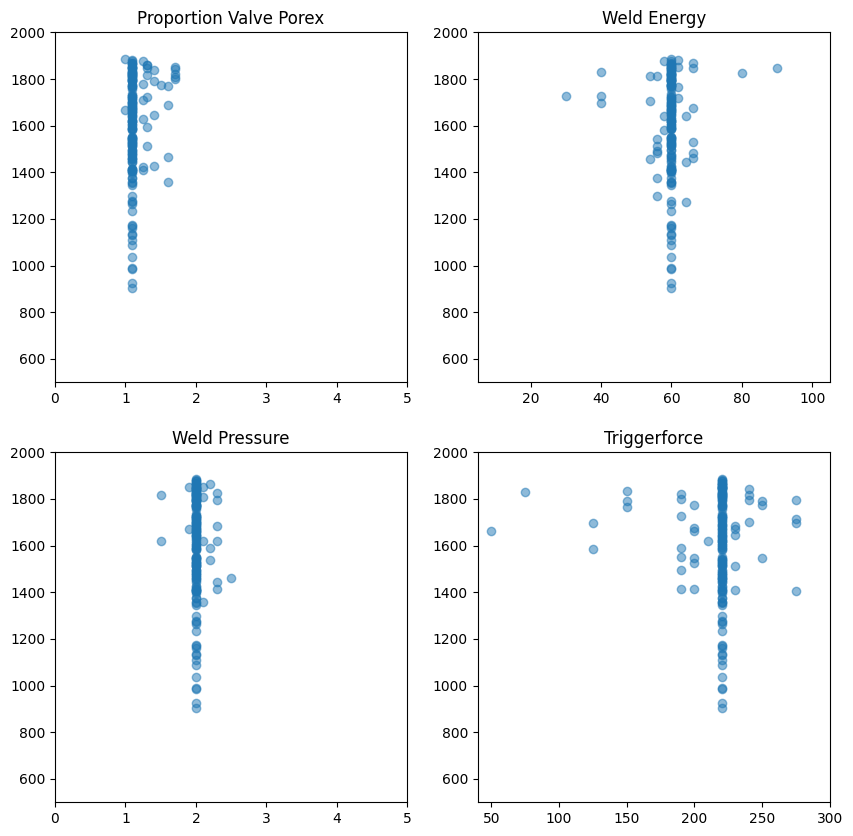

In [63]:
# plot 4 graphs
current_df = pd.concat([df0, dfc,df1,df2,df3,df4,df5])
current_df = current_df[current_df['Area sum']<1886]

fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].set_title("Proportion Valve Porex")
axs[0,0].scatter(current_df['Param1'], current_df['Area sum'], alpha=0.5)
axs[0,0].set_xlim(0,5)

axs[0,1].set_title("Weld Energy")
axs[0,1].scatter(current_df['Param2'], current_df['Area sum'], alpha=0.5)
axs[0,1].set_xlim(5,105)

axs[1,0].set_title("Weld Pressure")
axs[1,0].scatter(current_df['Param3'], current_df['Area sum'], alpha=0.5)
axs[1,0].set_xlim(0,5)

axs[1,1].set_title("Triggerforce")
axs[1,1].scatter(current_df['Param4'], current_df['Area sum'], alpha=0.5)
axs[1,1].set_xlim(40,300)


for i in range(4):
    axs[i//2, i%2].set_ylim(500, 2000)

#fig.suptitle("All data")

plt.show()

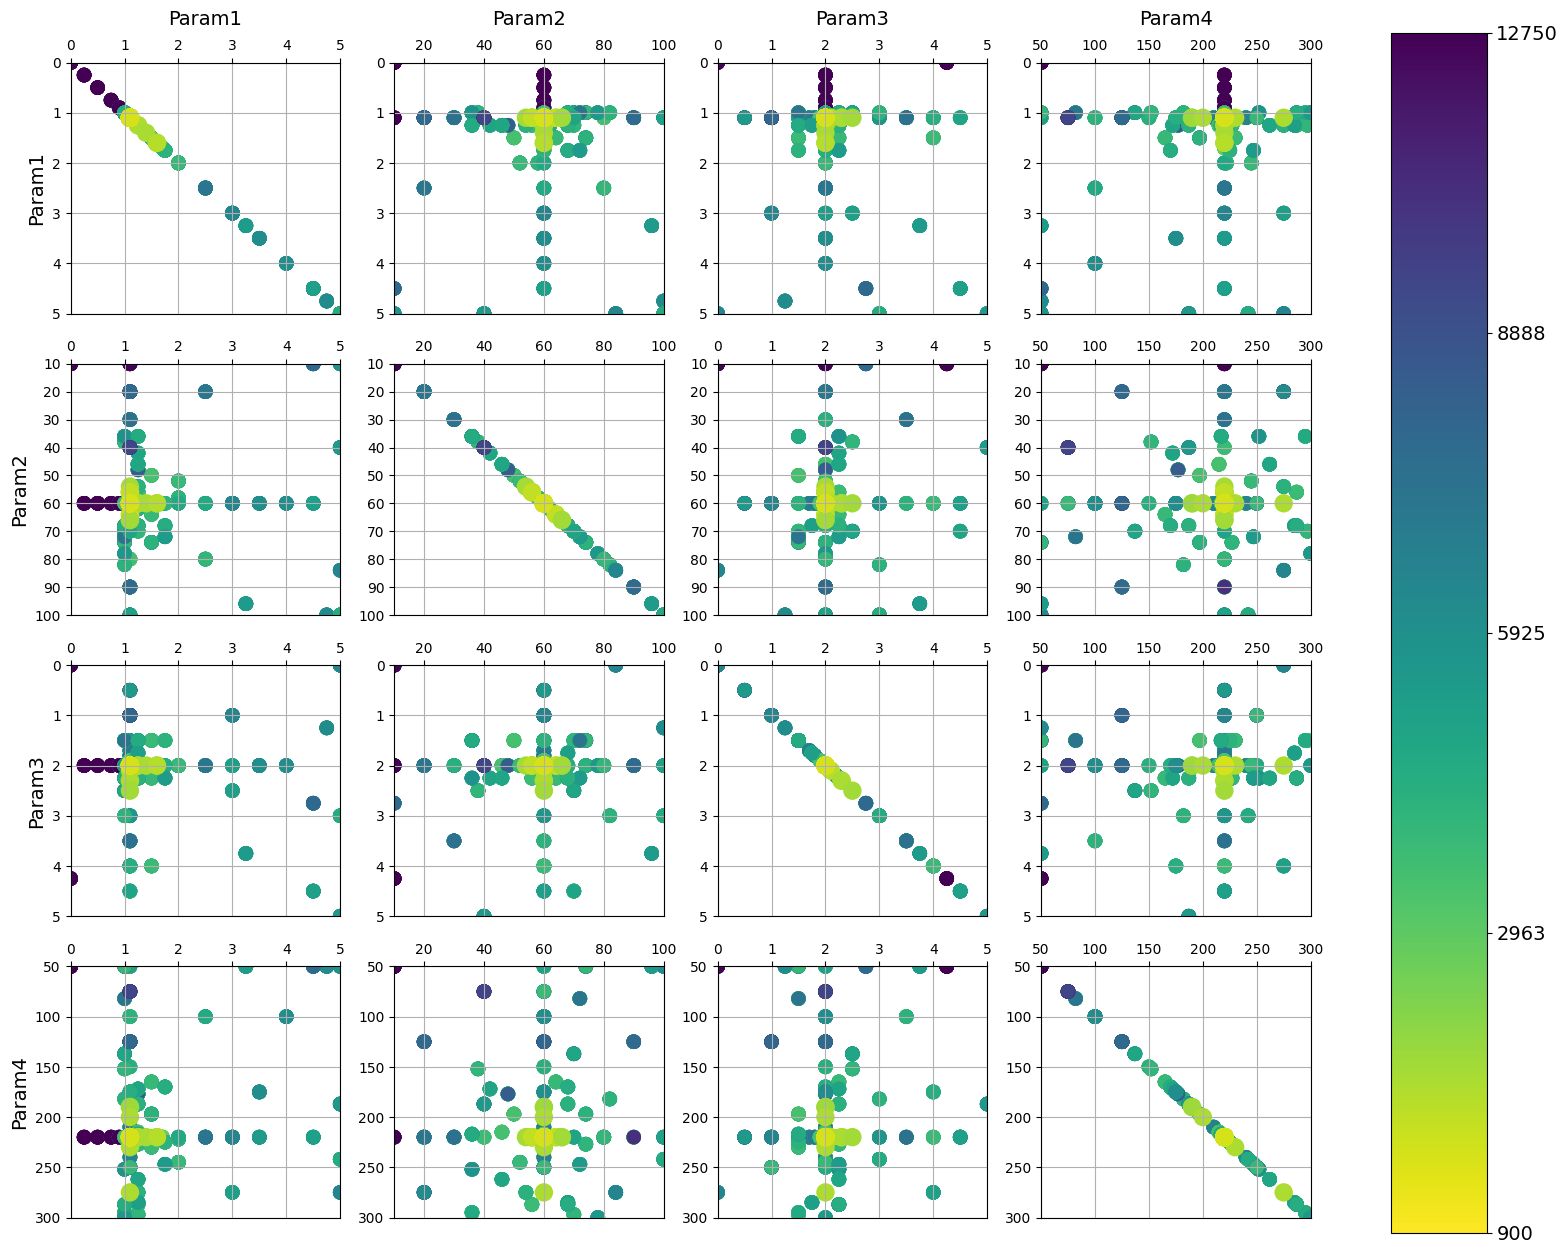

In [60]:
fig, axs = plt.subplots(4, 4, figsize=(16,15))

bounds = [(0,5),(10,100),(0,5),(50,300)]

# current_df['Area sum'][current_df['Area sum'] > 5000] = 5000

min_df = current_df[current_df['Area sum'] <= 1500]
max_df = current_df[current_df['Area sum'] > 1500]

for x in range(4):
    for y in range(4):
        
        
        scatter1 = axs[x,y].scatter(min_df['Param'+str(y+1)], min_df['Param'+str(x+1)], c=min_df['Area sum'], cmap='viridis_r', alpha=1, s=150, vmin=900, vmax=5000, zorder=1)
        #cbar1 = plt.colorbar(scatter1, ax=axs[x,y])

        axs[x,y].scatter(max_df['Param'+str(y+1)], max_df['Param'+str(x+1)], c=max_df['Area sum'], cmap='viridis_r', alpha=1, s=90, vmin=900, vmax=5000, zorder=0)
        

        axs[x,y].set_ylim(bounds[x])
        axs[x,y].set_xlim(bounds[y])
        axs[x,y].grid()
        axs[x,y].invert_yaxis()
        axs[x,y].xaxis.tick_top()



cax = fig.add_axes([0.95, 0.1, 0.06, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis_r')  # Example mappable object
cb = plt.colorbar(mappable=sm, cax=cax)

import matplotlib.ticker as ticker
tick_locator = ticker.MaxNLocator(nbins=10)  # Example: 5 tick intervals
tick_formatter = ticker.ScalarFormatter(useOffset=False)  # Example: Disable scientific notation
cb.locator = tick_locator
cb.formatter = tick_formatter

tick_positions = [0, 0.25, 0.5, 0.75, 1]
tick_labels = ['900', '2963', '5925', '8888', '12750']
cb.set_ticks(tick_positions)
cb.set_ticklabels(tick_labels)
cb.ax.tick_params(labelsize=14)
cb.update_ticks()


for i in range(4):
    axs[i,0].set_ylabel('Param'+str(i+1), fontsize=14)
    #axs[0,i].set_xlabel('Param'+str(i+1), fontsize=14)
    axs[0,i].text(0.5, 1.15, 'Param'+str(i+1), transform=axs[0,i].transAxes, ha='center', fontsize=14)


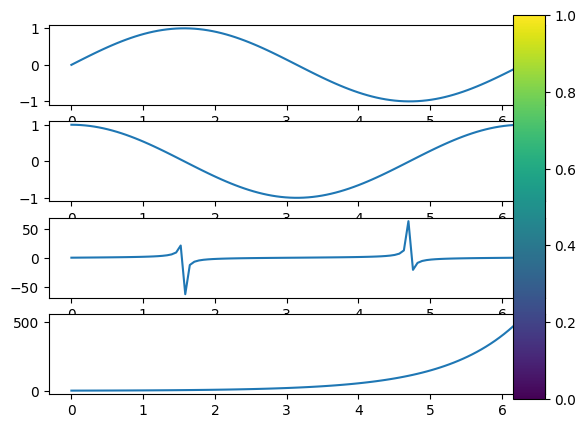

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create the subplots using gridspec
fig = plt.figure()
gs = gridspec.GridSpec(4, 1)  # 4 rows, 1 column

# Create the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First subplot
ax2 = fig.add_subplot(gs[1, 0])  # Second subplot
ax3 = fig.add_subplot(gs[2, 0])  # Third subplot
ax4 = fig.add_subplot(gs[3, 0])  # Fourth subplot

# Generate sample data
x = np.linspace(0, 2 * np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# Plot the data on the subplots
ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3)
ax4.plot(x, y4)

# Create a colorbar
cax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis')  # Example mappable object
cb = plt.colorbar(mappable=sm, cax=cax)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Prepare 3D data
x = np.array([1, 2, 4, 7, 9])  # Example x coordinates
y = np.array([2, 5, 6, 8, 9])  # Example y coordinates
z = np.array([3, 5, 2, 7, 4])  # Example z values

# Step 3: Create a grid of points
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

# Step 4: Plot the contour
plt.contourf(Xi, Yi, Zi, levels=20, cmap='viridis')
plt.colorbar()  # Add a color bar
plt.scatter(x, y, c=z, cmap='viridis')  # Plot the original data points
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot with Interpolation')
plt.show()


In [24]:
print(current_df['Area sum'].values.shape)
print(current_df['Param1'].shape)
print(current_df['Param2'].shape)


(1188,)
(1188,)
(1188,)


C:\Users\mpr.CMDK\AppData\Local\Temp\ipykernel_6564\1603772896.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Area sum'][current_df['Area sum'] > 5000] = 5000


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull v Qz Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 765264911  voronoi  Qz-infinity-point  Qcoplanar-keep  Qbbound-last
  _pre-merge  _zero-centrum  Qinterior-keep  Pgood  _max-width  5
  Error-roundoff 6.9e-15  _one-merge 4.9e-14  Visible-distance 1.4e-14
  U-max-coplanar 1.4e-14  Width-outside 2.8e-14  _wide-facet 8.3e-14
  _maxoutside 5.5e-14

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p635(v4):   2.5   2.5   1.1
- p1188(v3):   1.5   1.5     5
- p1100(v2):     5     5   4.5
- p1118(v1):     0     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 6.9e-15.  The center point, facets and distances
to the center point are as follows:

center point    2.258    2.258     2.67

facet p1188 p1100 p1118 distance=    0
facet p635 p1100 p1118 distance=    0
facet p635 p1188 p1118 distance=    0
facet p635 p1188 p1100 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0         5  difference=    5
  1:         0         5  difference=    5
  2:         0         5  difference=    5

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 6.9e-15.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


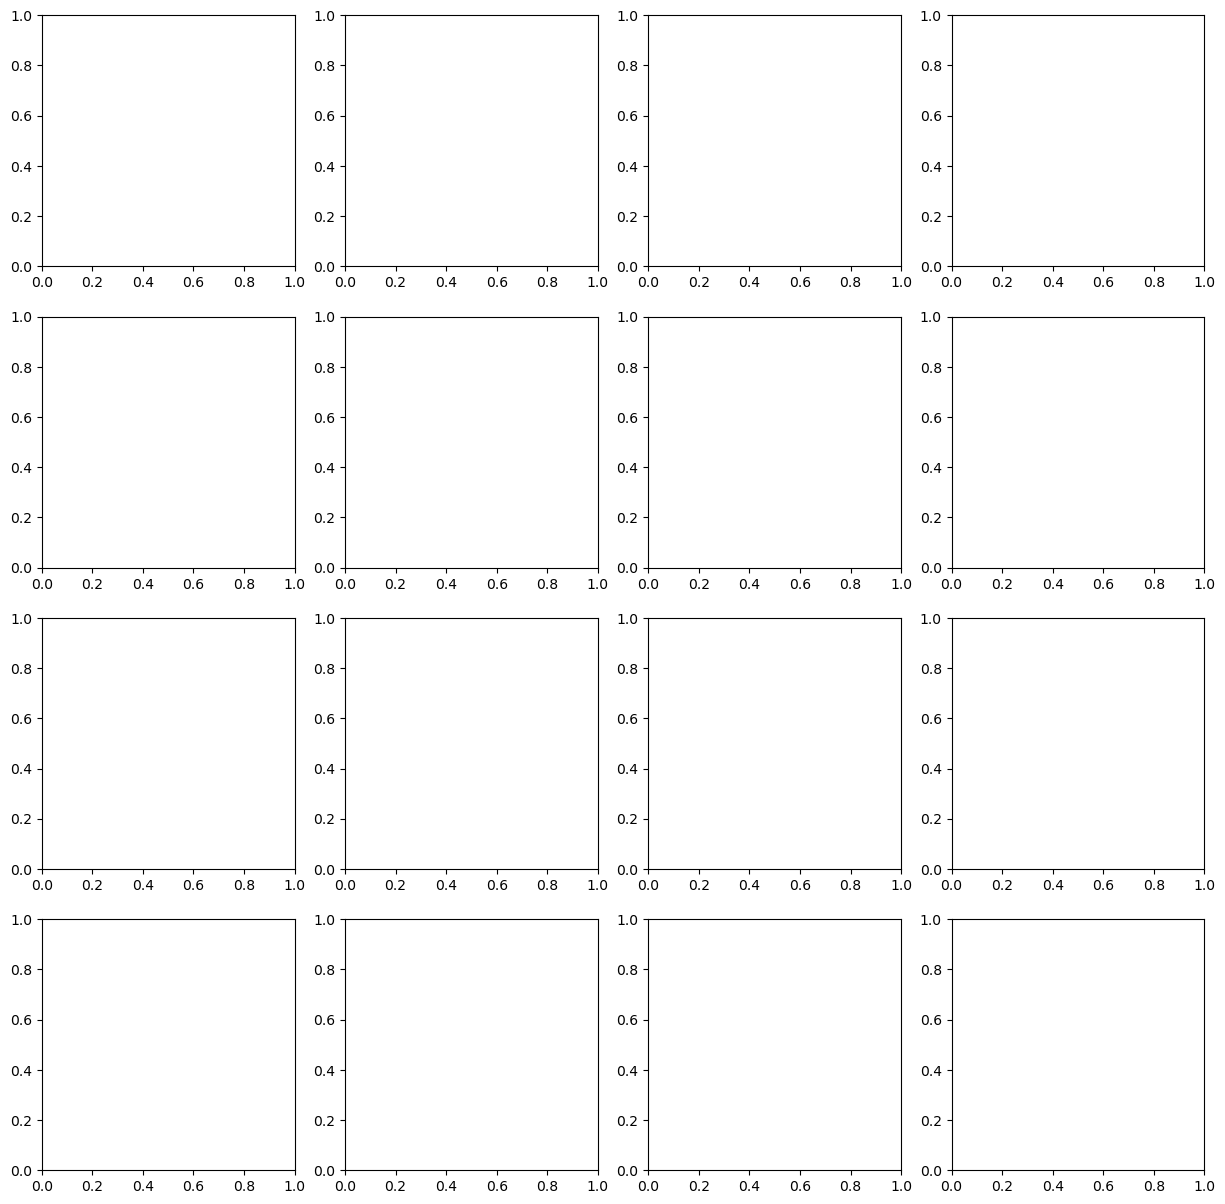

In [52]:
from scipy.ndimage import gaussian_filter, median_filter
from scipy.spatial import Voronoi, voronoi_plot_2d


fig, axs = plt.subplots(4, 4, figsize=(15,15))

bounds = [(0,5),(10,100),(0,5),(50,300)]

current_df['Area sum'][current_df['Area sum'] > 5000] = 5000

min_df = current_df[current_df['Area sum'] <= 1500].copy()
max_df = current_df[current_df['Area sum'] > 1500].copy()

for x in range(4):
    for y in range(4):
        
        xvals = current_df['Param'+str(y+1)].values
        yvals = current_df['Param'+str(x+1)].values
        # zvals = current_df['Area sum'].values
        # zvals = (zvals - zvals.mean()) / (zvals.std() + 1e-9) 
        # zvals = gaussian_filter(zvals, sigma=1)
        # xi = np.linspace(bounds[x][0], bounds[x][1], 100)
        # yi = np.linspace(bounds[y][0], bounds[y][1], 100)
        # Xi, Yi = np.meshgrid(xi,yi) 
        # Zi = griddata((xvals, yvals), zvals, (Xi, Yi), method='nearest')
        # axs[x,y].contour(Xi, Yi, Zi, levels=20, cmap='viridis_r')

        scatter1 = axs[x,y].scatter(min_df['Param'+str(y+1)], min_df['Param'+str(x+1)], c=min_df['Area sum'], cmap='viridis_r', alpha=1, s=50, vmin=900, vmax=5000, zorder=1)
        cbar1 = plt.colorbar(scatter1, ax=axs[x,y])
        axs[x,y].scatter(max_df['Param'+str(y+1)], max_df['Param'+str(x+1)], c=max_df['Area sum'], cmap='viridis_r', alpha=1, s=60, vmin=900, vmax=5000, zorder=0)
        

        axs[x,y].set_ylim(bounds[x])
        axs[x,y].set_xlim(bounds[y])
        axs[x,y].grid()
        axs[x,y].invert_yaxis()
        axs[x,y].xaxis.tick_top()



for i in range(4):
    axs[i,0].set_ylabel('Param'+str(i+1), fontsize=14)
    #axs[0,i].set_xlabel('Param'+str(i+1), fontsize=14)
    axs[0,i].text(0.5, 1.15, 'Param'+str(i+1), transform=axs[0,i].transAxes, ha='center', fontsize=14)
